## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests
import glob
import random

import torch
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import cv2

import models

# RES = 224
RES = 512

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.5,0.5,0.5])
imagenet_std = np.array([0.5,0.5,0.5])

def show_image(image, title=''):
    # image is [V, H, W, 3]
    assert image.shape[3] == 3
    image = image.view(-1,min(4, image.shape[0]),RES,RES,3)
    image = torch.einsum('pqhwc->phqwc', image).flatten(2,3).flatten(0,1)
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir):
    # build model
    model = models.large(num_ref=1)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    model.eval()
    print(msg)
    return model

def crop(img):
    width, height = img.size

    # Determine the side length of the square
    square_side = min(width, height)

    # Calculate crop box coordinates for a centered square
    left = (width - square_side) / 2
    top = (height - square_side) / 2
    right = (width + square_side) / 2
    bottom = (height + square_side) / 2

    # Crop the image
    cropped_img = img.crop((left, top, right, bottom))
    return cropped_img.resize((RES, RES))

@torch.no_grad()
def run_one_image(imgs, model):
    x = torch.tensor(imgs)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('bvhwc->bvchw', x)

    # run Muskie
    # randidate mask_modes: random, rectangle, ellipse and blob
    loss, _, y, conf, mask = model(x.float(), mask_mode=('random', 'rectangle', 'ellipse'), mask_ratio=(0.9, 0.75, 0.75))
    conf = conf.mean(dim=2, keepdim=True).repeat(1,1,3,1,1)
    conf = conf * 2 - 1
    y = torch.einsum('bvchw->bvhwc', y).cpu()
    conf = torch.einsum('bvchw->bvhwc', conf).cpu()

    # visualize the mask
    mask = mask.unsqueeze(2).repeat(1, 1, model.patch_size**2 *3, 1)  # (B, V, p*p*3, H*W)
    mask = mask.view(y.shape[0], y.shape[1], -1, y.shape[2]//model.patch_size, y.shape[3]//model.patch_size)
    mask = F.pixel_shuffle(mask, model.patch_size)
    mask = torch.einsum('bvchw->bvhwc', mask)
    
    x = torch.einsum('bvchw->bvhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # Muskie reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask
    conf_paste = x * (1 - mask) + conf * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [12.5, 17.5]

    plt.subplot(5, 1, 1)
    show_image(x[0], "original")

    plt.subplot(5, 1, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(5, 1, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(5, 1, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.subplot(5, 1, 5)
    show_image(conf_paste[0], "confidence + visible")

    plt.show()

### Load a pre-trained MAE model

In [3]:
# download checkpoints and example images
chkpt_dir = 'checkpoints/muskie-large.pth'
model_mae = prepare_model(chkpt_dir)
print('Model loaded.')

/tmp/ipykernel_4134444/3236279845.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


<All keys matched successfully>
Model loaded.


### Load an image

/tmp/ipykernel_4134444/3444160116.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  show_image(torch.tensor(imgs))


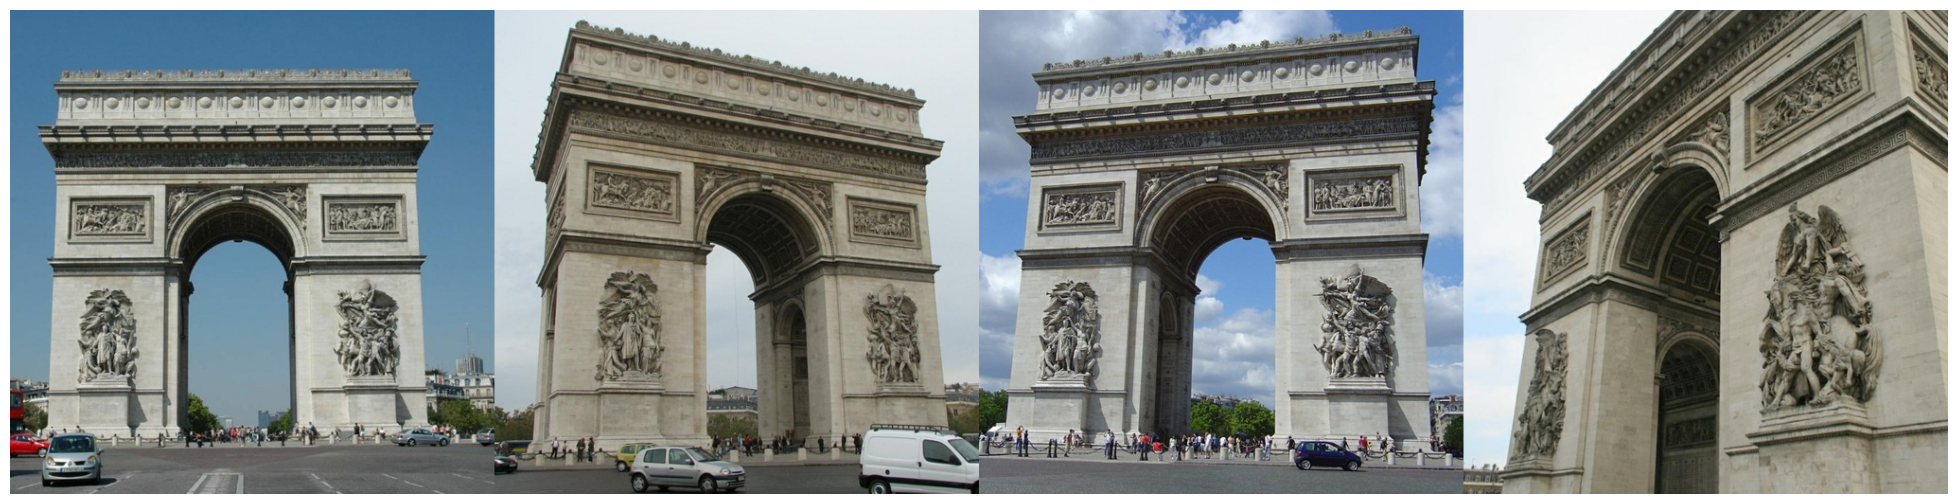

In [4]:
filenames = glob.glob('examples/*.jpg')
imgs = [np.array(crop(Image.open(f))) / 255. for f in filenames]
# normalize by ImageNet mean and std
imgs = [(img - imagenet_mean) / imagenet_std for img in imgs]

plt.rcParams['figure.figsize'] = [25, 25]
show_image(torch.tensor(imgs))

### Run MAE on the image

Muskie multi-view reconstruction:


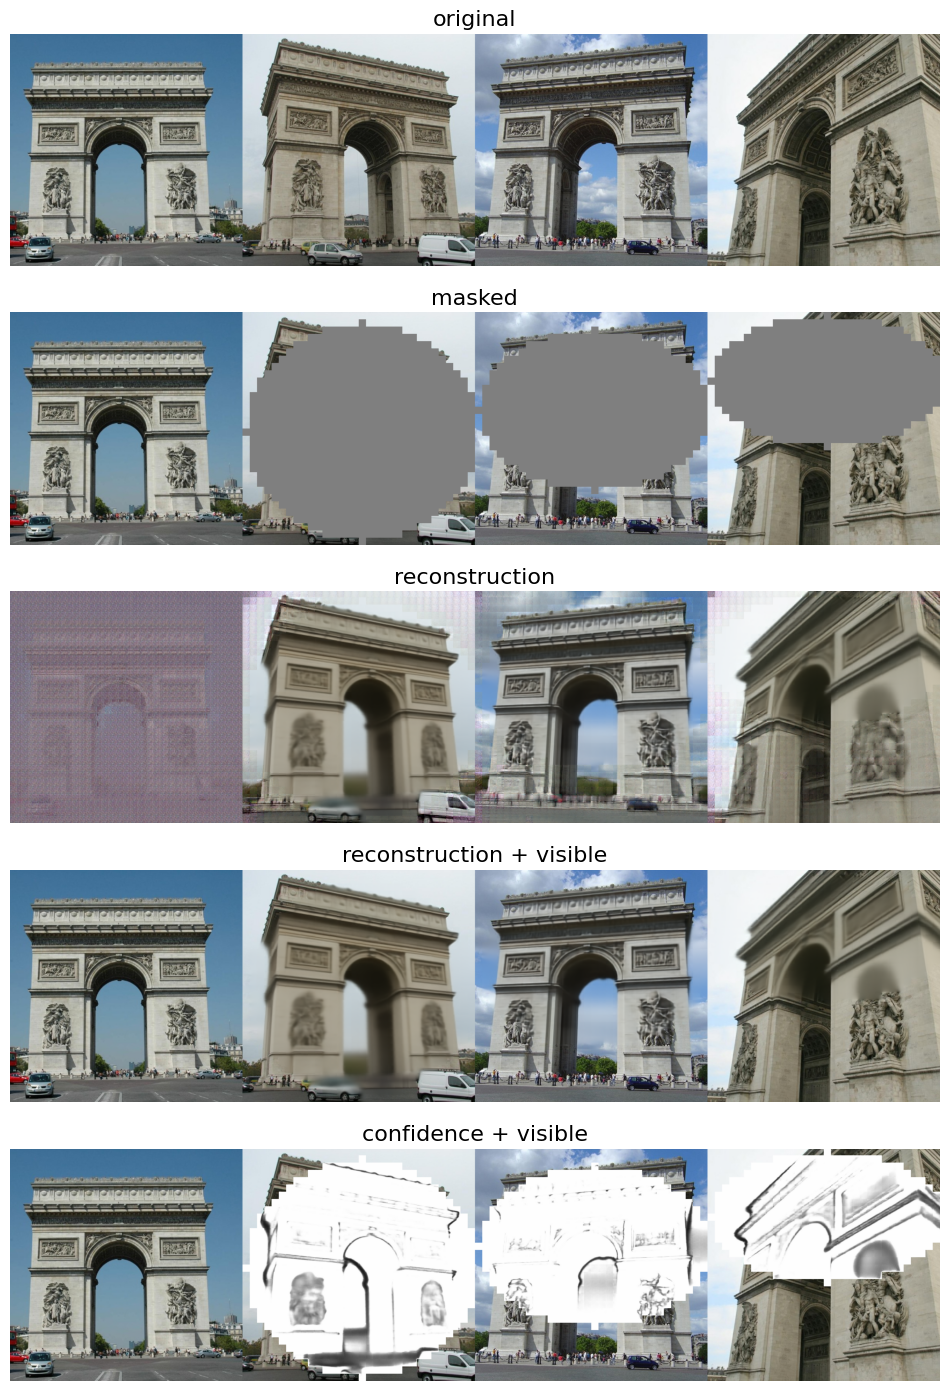

In [5]:
print('Muskie multi-view reconstruction:')
run_one_image(imgs, model_mae)